# Blackjack

"*Winner winner chicken dinner!*" - *21*

[Great movie reference!](https://it.wikipedia.org/wiki/21_(film))

The origins of Blackjack is still under debate.
There is a theory that dates it back to the Romans, however it probably comes from French casinos around 1700.
The card game was surely played at the French Royal Court during the reign of King Louis XV, and it was called "Vingt-et-Un".

We will deal with the modern version of the game, which became established around the 19th century. We will consider only heads-ups, in which the other player is the dealer.

Rules:
- **Objective**: obtain cards whose sum is as close as possible to 21, without exceeding it.
- **Values**: It is up to each individual player if an ace is worth 1 or 11. Face cards are 10 and any other card is its pip value.
- **Start**: At the beginning each player draws 2 cards. The actual player holds them face up, while the dealer reveals only 1 card to the other player and leave the other face down. If the player drew an ace and a 10-card its turn never begins, as it holds already 21 and cannot improve its score: it is called a *natural*.
- **Play**: The player can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust). If he goes bust, he loses; if he sticks, then it becomes the dealer’s turn. In standard Blackjack the dealer can perform the same actions as the player, however he hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise.
- **Scoring**: When one of the players go bust the game ends and that player loses; otherwise, the outcome — win, lose, or draw — is determined by whose final sum is closer to 21.

We don't take into account the possibility of splitting. The *split* is offered when a player’s initial two-card hand includes two cards of the same value. It gives the player the option of splitting the cards into two separate hands, then receiving an additional card for each hand from the dealer.

Playing blackjack is naturally formulated as an episodic finite MDP: each game of blackjack is an episode.

- **Reward**: +1, -1, and 0 for winning, losing, and drawing, respectively. All rewards within a game are zero, and we do not discount ($\gamma$ = 1); therefore these terminal rewards are also the returns.
- **Action**: the player’s actions are to hit or to stick.
- **State**: The states depend on the player’s cards and the dealer’s showing card. *Important*! We assume that cards are dealt from an infinite deck (i.e., with replacement) so that there is no advantage to keeping track of the cards already dealt.
Also, if the player holds an ace that he could count as 11 without going bust, then the ace is said to be *usable*. In this case it is always counted as 11.
The player makes decisions on the basis of three variables: his current sum (12–21), the dealer’s one showing card (ace–10), and whether or not he holds a usable ace. This makes for a total of 200 states.

With the following notebook we will see in action different algorithms related to the **Monte Carlo** structure. We will address both the tasks of prediction and control, and we will make use of on-policy and off-policy schemes.


**Credits and Imports**


In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Nicky van Foreest(vanforeest@gmail.com)                        #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


**Setting up the policies** both for player and dealer. The player can be assigned the policy that sticks if the player’s sum is 20 or 21, and otherwise hits. The dealer sticks on any sum of 17 or greater, and hits otherwise.

Definition of a behaviour policy (random action) for the player.


In [ ]:
# actions: hit or stand
ACTION_HIT = 0
ACTION_STAND = 1  # "strike" in the book
# Actually it is neither "stand" nor "strike", it is "stick"
ACTIONS = [ACTION_HIT, ACTION_STAND]

# policy for player
# Hard-coded policy! Sticks only if sum >= 20!
POLICY_PLAYER = np.zeros(22, dtype=int)
POLICY_PLAYER[20] = ACTION_STAND
POLICY_PLAYER[21] = ACTION_STAND

# function form of target policy of player
# In general a policy may depend on all the arguments, here we only care about 'player_sum'
def target_policy_player(usable_ace_player, player_sum, dealer_card):
    return POLICY_PLAYER[player_sum]

# function form of behavior policy of player
# Also here the line above applies, no argument at all in this case
def behavior_policy_player(usable_ace_player, player_sum, dealer_card):
    # Bernoulli distribution: completely random action!
    if np.random.binomial(1, 0.5) == 1:
        return ACTION_STAND
    return ACTION_HIT

# policy for dealer
POLICY_DEALER = np.zeros(22)
for i in range(17, 22):
    POLICY_DEALER[i] = ACTION_STAND

**Useful functions** related to the environment: draw a card and aces values management.


In [ ]:
# get a new card
def get_card():
    card = np.random.randint(1, 14)  # jack queen king, exclusive!
    # Face cards count as 10!
    card = min(card, 10)
    return card

# get the value of a card (11 for ace).
def card_value(card_id):
    return 11 if card_id == 1 else card_id


**Main function** for playing the game of Blackjack.

Some features of this function are there just to help us with the following tasks, e.g.:
- It is possible to specify the first action. This is done to ease the implementation of *Monte Carlo Exploring Starts*.
- The whole trajectory is stored: this allows us to update the estimate of every state (or state-action pair encountered in the different games).

The function indeed takes as argument a policy, an initial state and an initial action, and **outputs a tuple with the final state, the reward, and the whole encountered trajectory of state-action pairs**.

First there is the initialization of the initial state if None is provided, then we will manage the behaviour of the player with a while loop, as for the dealer. At the end we compute the verdict of the game.


In [ ]:
# play a game
# @policy_player: specify policy for player
# @initial_state: [whether player has a usable Ace, sum of player's cards, one card of dealer]
# A player cannot have more than 1 usable ace!
# @initial_action: the initial action
def play(policy_player, initial_state=None, initial_action=None):
    # player status

    # sum of player
    player_sum = 0

    # trajectory of player
    player_trajectory = []

    # whether player uses Ace as 11
    # This variable is True if the player has an ace that it is being used as 11
    usable_ace_player = False

    # dealer status
    dealer_card1 = 0
    dealer_card2 = 0
    usable_ace_dealer = False

    ###
    # NOW WE SET THE INITIAL CARDS FOR BOTH PLAYER AND DEALER, BEFORE STARTING THE GAME!
    ###

    if initial_state is None:
        # generate a random initial state

        # If initial_state is None we will surely draw at least 2 cards
        # Always safe to hit when sum is less than 12
        while player_sum < 12:
            # if sum of player is less than 12, always hit
            card = get_card()
            player_sum += card_value(card)

            # If the player's sum is larger than 21, he may hold one or two aces.
            if player_sum > 21:
                # The only value sum can assume is 22 because we are increasing sum by a value smaller than 11 starting
                # from less than 12
                assert player_sum == 22
                # last card must be ace
                player_sum -= 10
                # Rearranged the value of the ace, and we do not need to have usable aces anymore
            # We check this every time!
            else:
                # OR assignment! If an ace has been drawn, update the usable_ace_player variable to 1
                # equal to: usable_ace_player = usable_ace_player | (1 == card)
                usable_ace_player |= (1 == card)    # |= is an "OR" operator

        # initialize cards of dealer, suppose dealer will show the first card he gets
        dealer_card1 = get_card()
        dealer_card2 = get_card()

    # If we want instead to initialize the state
    # We cannot impose anything on the second card of the dealer as it is out of our control!
    else:
        # use specified initial state
        usable_ace_player, player_sum, dealer_card1 = initial_state
        dealer_card2 = get_card()

    # initial state of the game
    state = [usable_ace_player, player_sum, dealer_card1]

    # Initial dealer sum may be 22, that's why we keep a variable for its second card

    # initialize dealer's sum
    dealer_sum = card_value(dealer_card1) + card_value(dealer_card2)
    usable_ace_dealer = 1 in (dealer_card1, dealer_card2)  # returns True if it has at least one ace
    # if the dealer's sum is larger than 21, he must hold two aces.
    if dealer_sum > 21:
        assert dealer_sum == 22
        # use one Ace as 1 rather than 11
        dealer_sum -= 10
        # Again the amount of usable aces remains unchanged (there have never been 2 actually)
    assert dealer_sum <= 21
    assert player_sum <= 21

    ###
    # GAME STARTS!
    ###

    # player's turn
    while True:
        if initial_action is not None:
            action = initial_action
            initial_action = None
        else:
            # get action based on current sum
            # policy_player is either target_policy_player or behaviour_policy_player (in fact, in off-policy methods, the episodic experience is sampled following the behaviour policy!)
            action = policy_player(usable_ace_player, player_sum, dealer_card1)

        # track player's trajectory for importance sampling
        # Storing state-action pair
        player_trajectory.append([(usable_ace_player, player_sum, dealer_card1), action])

        if action == ACTION_STAND: #stick
            break  # exit the loop
        # if hit, get new card
        card = get_card()
        # Keep track of the ace count. the usable_ace_player flag is insufficient alone as it cannot
        # distinguish between having one ace or two.
        # This may happen only if we draw an ace and we already drew one before, but one should immediately marked as
        # 'not usable'
        ace_count = int(usable_ace_player)   # we cannot have 2 aces simultaneously!
        if card == 1:
            ace_count += 1
        player_sum += card_value(card)
        # If the player has at least a usable ace, use it as 1 to avoid busting and continue.
        while player_sum > 21 and ace_count:  # if we busted out and we have at least one usable ace
            player_sum -= 10
            ace_count -= 1
        # player busts
        if player_sum > 21:
            return state, -1, player_trajectory  # reward = -1, we lost the game
        assert player_sum <= 21
        # It gets re-initialized before each action selection from the player
        usable_ace_player = (ace_count == 1)

    # dealer's turn
    while True:
        # get action based on current sum
        # The policy is actually an array
        action = POLICY_DEALER[dealer_sum]
        if action == ACTION_STAND:
            break  # exit the loop
        # if hit, get a new card
        new_card = get_card()
        ace_count = int(usable_ace_dealer)
        if new_card == 1:
            ace_count += 1
        dealer_sum += card_value(new_card)
        # If the dealer has a usable ace, use it as 1 to avoid busting and continue.
        while dealer_sum > 21 and ace_count:
            dealer_sum -= 10
            ace_count -= 1
        # dealer busts
        if dealer_sum > 21:
            return state, 1, player_trajectory  # reward = 1, we won the game
        usable_ace_dealer = (ace_count == 1)

    # Determine the winner if no one busted out
    # compare the sum between player and dealer
    assert player_sum <= 21 and dealer_sum <= 21
    if player_sum > dealer_sum:
        return state, 1, player_trajectory  # Win
    elif player_sum == dealer_sum:
        return state, 0, player_trajectory  # Draw
    else:
        return state, -1, player_trajectory  # Lose


**Monte Carlo algorithm**: *every-visit* implementation, for *prediction only*.

We will compute the value-function for the target policy defined above.
Here we partition the state-space (of size 200) into two matrices of size 100 each. We distinguish them by the binary variable `usable_ace`.
As the Monte Carlo algorithm prescribes, we unroll the whole trajectory, and we update the unbiased estimate of the return accordingly.


In [ ]:
# Monte Carlo Sample with On-Policy
def monte_carlo_on_policy(episodes):
    # all states given that the player have a usable ace: 10 possible values of sum
    # times ten possible values for the card face up = 100
    states_usable_ace = np.zeros((10, 10))
    # initialize counts to 1 to avoid 0 being divided
    # counting the visits to any state
    states_usable_ace_count = np.ones((10, 10))
    # same for the case of no usable ace
    states_no_usable_ace = np.zeros((10, 10))
    # initialize counts to 1 to avoid 0 being divided
    states_no_usable_ace_count = np.ones((10, 10))
    for i in tqdm(range(0, episodes)): #tqdm() is used to create progress bar
        _, reward, player_trajectory = play(target_policy_player) #give the function target_policy_player() as argument
        for (usable_ace, player_sum, dealer_card), _ in player_trajectory:
            player_sum -= 12  # so that it ranges from 0 to 9, we use this as index for the rows of the value-state matrix
            dealer_card -= 1  # same: ranging from 0 to 9, we use this as index for the columns of the value-state matrix
            if usable_ace:
                states_usable_ace_count[player_sum, dealer_card] += 1
                states_usable_ace[player_sum, dealer_card] += reward  # sum of returns
            else:
                states_no_usable_ace_count[player_sum, dealer_card] += 1
                states_no_usable_ace[player_sum, dealer_card] += reward  # sum of returns
    # return the mean of the returns
    return states_usable_ace / states_usable_ace_count, states_no_usable_ace / states_no_usable_ace_count


The above implementation of the *Monte Carlo algorithm* exploits the fact that the discount factor is $\gamma$=1 so that we can parse the trajectory in any order.
Note that it would not have made any difference if we had wanted to apply the *first-visit* version, since it is impossible to encounter two equal states in the same run: the state is indeed "monotonically increasing" (considering also the `usable_ace` variable) within a single game.


**Monte Carlo Exploring-Starts**: *first-visit* implementation, for *control*!

With this algorithm we estimate the action-value function of the current policy and we update the policy accordingly, i.e. we will always be using a greedy policy with respect to the current estimate.


In [ ]:
# Monte Carlo with Exploring Starts
def monte_carlo_es(episodes):
    # here we estimate the action-value function!
    # (playerSum, dealerCard, usableAce, action)
    state_action_values = np.zeros((10, 10, 2, 2))
    # initialize counts to 1 to avoid division by 0
    state_action_pair_count = np.ones((10, 10, 2, 2))

    # target/behavior policy is greedy
    def behavior_policy(usable_ace, player_sum, dealer_card):
        usable_ace = int(usable_ace)
        player_sum -= 12
        dealer_card -= 1
        # get argmax of the average returns(s, a)
        # entry-wise division
        values_ = state_action_values[player_sum, dealer_card, usable_ace, :] / \
                  state_action_pair_count[player_sum, dealer_card, usable_ace, :]
        # return the argmax and break ties randomly
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # play for several episodes
    for episode in tqdm(range(episodes)):
        # for each episode, use a randomly initialized state and action (EXPLORING START!!!)
        # it is not the same as initializing the initial state to None!
        initial_state = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initial_action = np.random.choice(ACTIONS)
        # Use the target policy in the first game (in the first game: episode == 0 (False)): we do not yet have an estimate on which to base a greedy policy!
        # (Nested/inner functions like 'behavior policy()'can access variables of the enclosing scope)
        current_policy = behavior_policy if episode else target_policy_player
        _, reward, trajectory = play(current_policy, initial_state, initial_action)
        # The set is probably here just to stress the fact that we want a first-visit algorithm!
        first_visit_check = set()
        for (usable_ace, player_sum, dealer_card), action in trajectory:
            # always to make the variables compatible with the state description
            usable_ace = int(usable_ace)
            player_sum -= 12
            dealer_card -= 1
            state_action = (usable_ace, player_sum, dealer_card, action)
            if state_action in first_visit_check:
                print('This line should never appear!')
                continue
            first_visit_check.add(state_action)
            # update values of state-action pairs
            state_action_values[player_sum, dealer_card, usable_ace, action] += reward
            state_action_pair_count[player_sum, dealer_card, usable_ace, action] += 1

    return state_action_values / state_action_pair_count


**Off-Policy Monte Carlo prediction**: both *ordinary* and *weighted* sampling.

We want to estimate the value-function using the target policy defined at the beginning for a fixed state.
The latter is defined in the very first line of the function.

In [ ]:
# Monte Carlo Sample with Off-Policy
def monte_carlo_off_policy(episodes):
    initial_state = [True, 13, 2]

    rhos = []
    returns = []

    for i in range(0, episodes):
        # Uses the random policy defined at the beginning
        _, reward, player_trajectory = play(behavior_policy_player, initial_state=initial_state)

        # get the importance ratio
        numerator = 1.0
        denominator = 1.0
        for (usable_ace, player_sum, dealer_card), action in player_trajectory:
            # target_policy_player is a deterministic policy, so numerator is either 1 or 0
            if action == target_policy_player(usable_ace, player_sum, dealer_card):
                denominator *= 0.5  # random probability between 2 values
            else:
                numerator = 0.0
                break
        rho = numerator / denominator
        rhos.append(rho)
        returns.append(reward)

    rhos = np.asarray(rhos)
    returns = np.asarray(returns)
    weighted_returns = rhos * returns

    weighted_returns = np.add.accumulate(weighted_returns)
    rhos = np.add.accumulate(rhos)

    ordinary_sampling = weighted_returns / np.arange(1, episodes + 1)

    with np.errstate(divide='ignore',invalid='ignore'):
        weighted_sampling = np.where(rhos != 0, weighted_returns / rhos, 0)

    return ordinary_sampling, weighted_sampling


**Figure 5.1**: plot of the learned state-value function for the hard-coded policy defined at the beginning of the notebook, `target_policy_player`.

Comparison between different number of episodes used to estimate the function (10000 and 500000).


100%|██████████| 500000/500000 [00:22<00:00, 22431.77it/s]


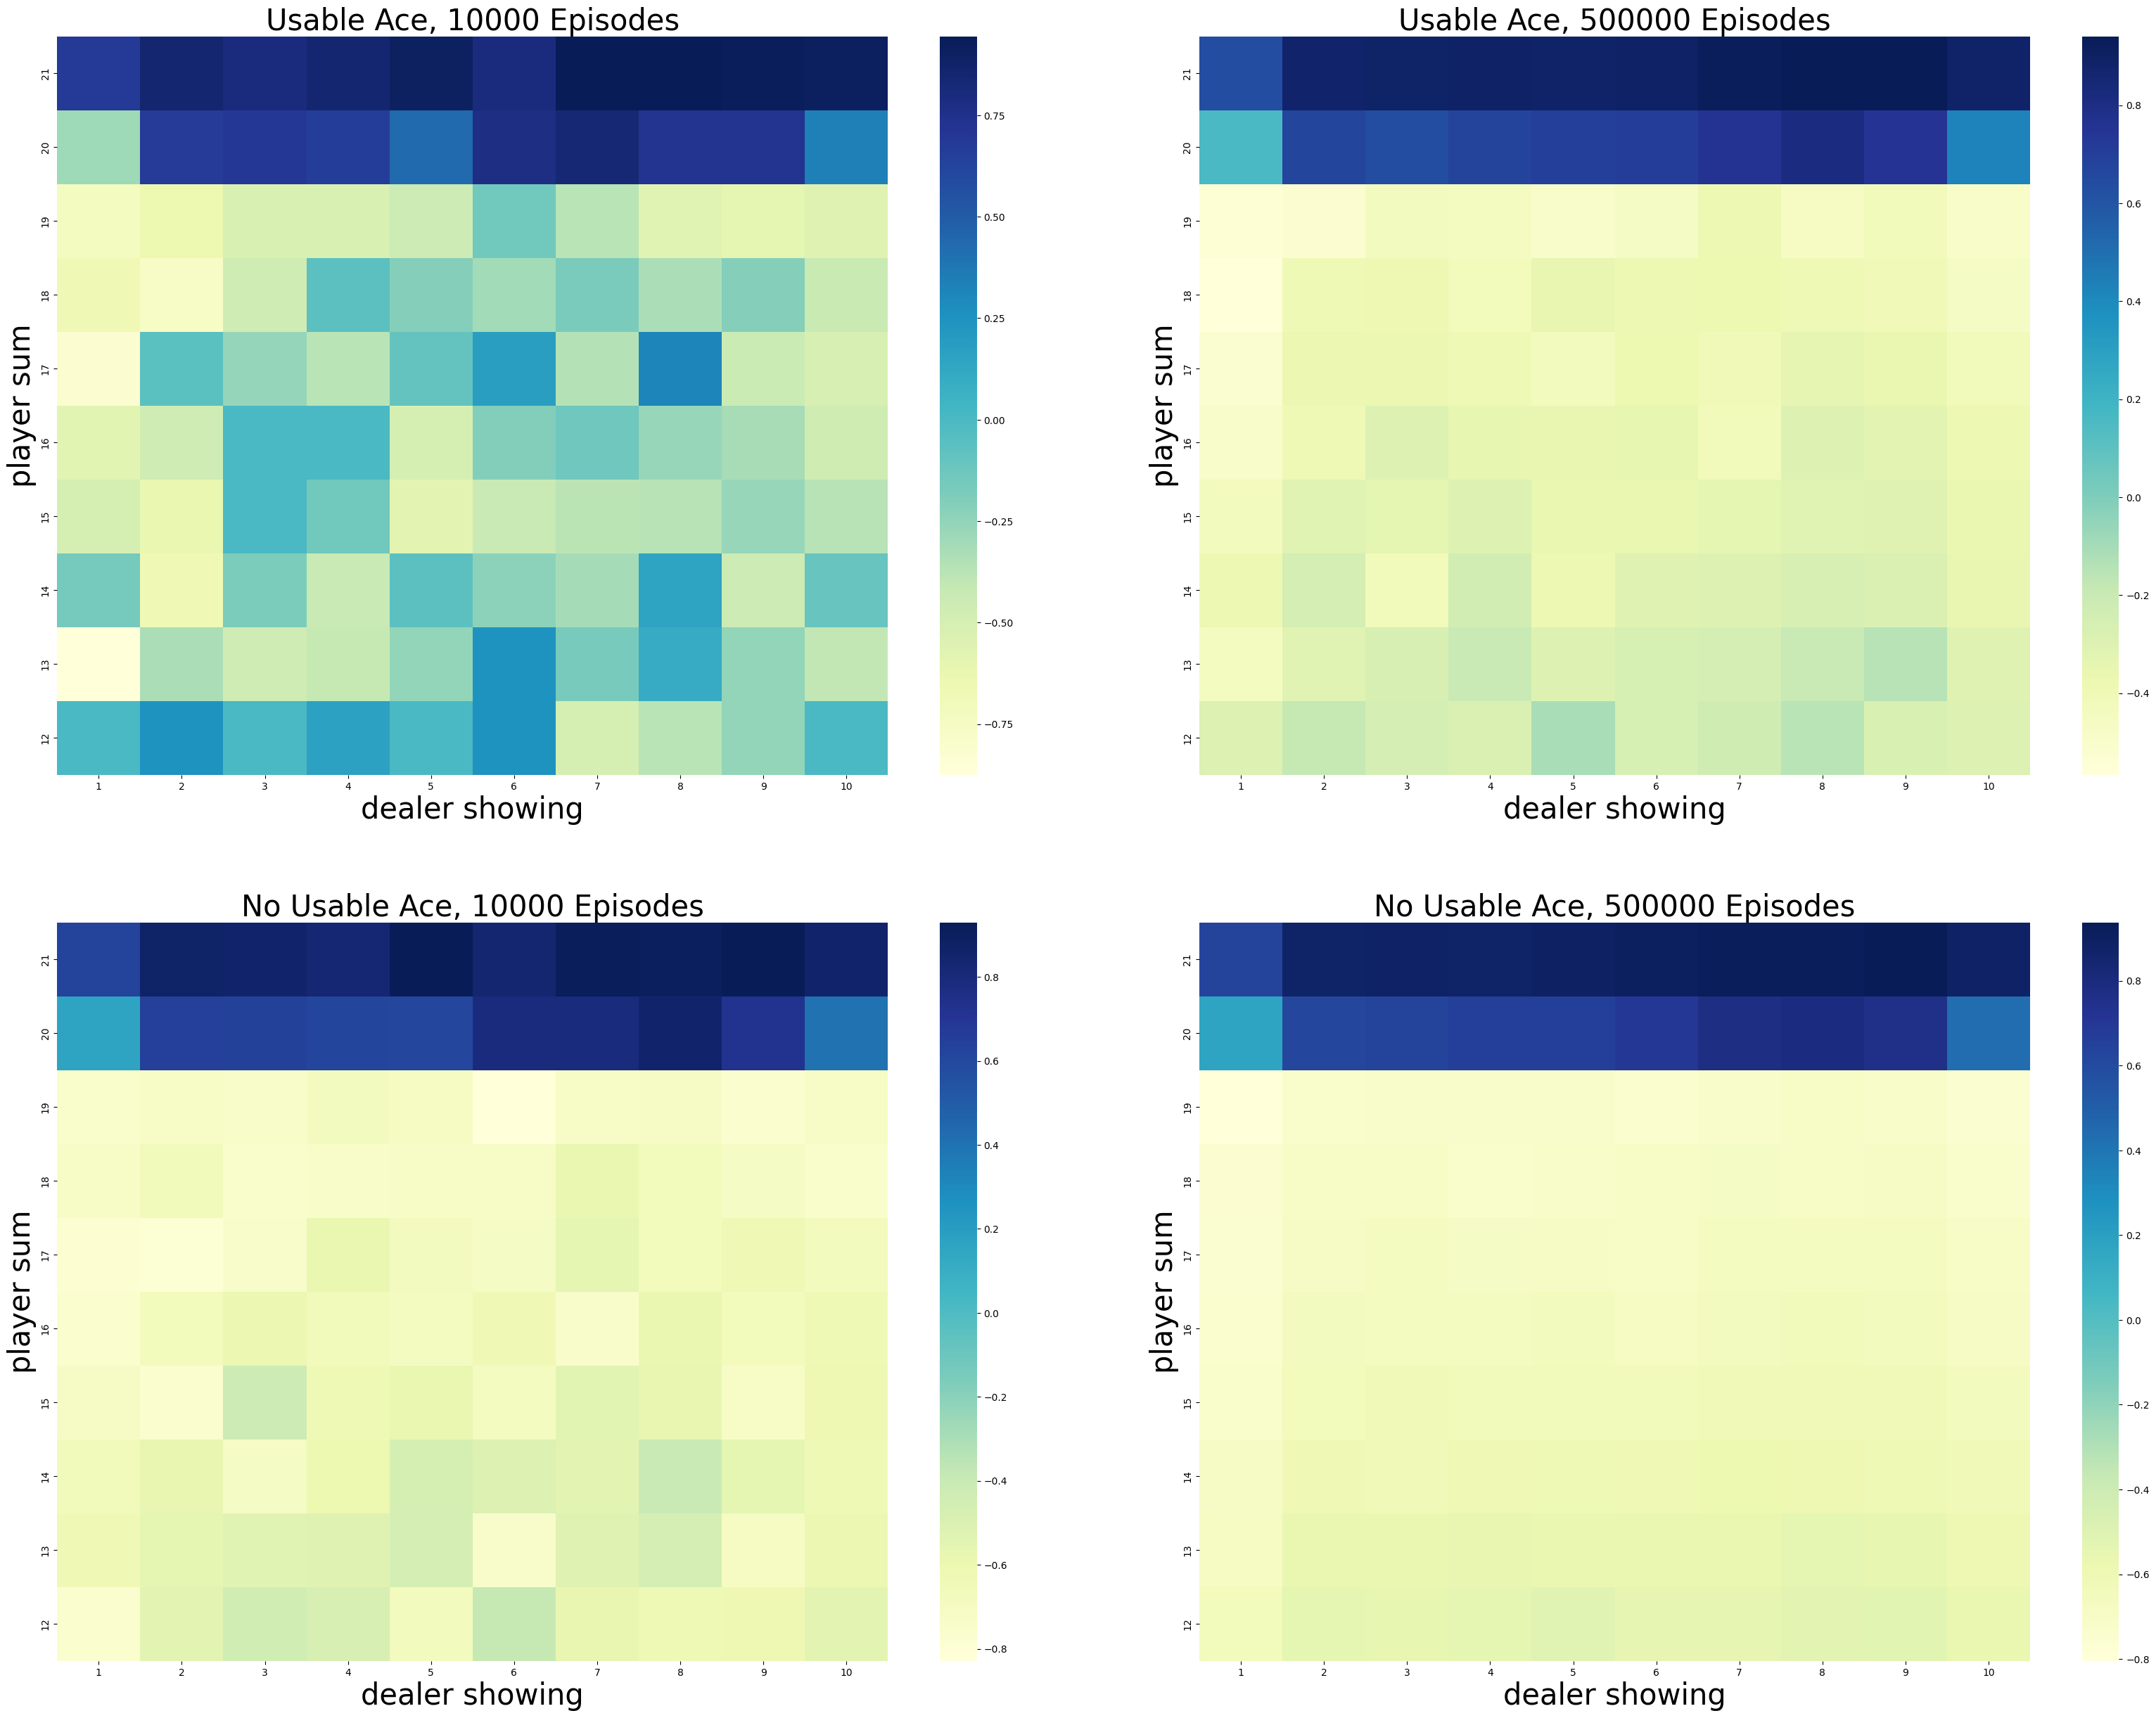

In [ ]:
# recall that monte_carlo_on_policy returns two separate matrices
states_usable_ace_1, states_no_usable_ace_1 = monte_carlo_on_policy(10000)
states_usable_ace_2, states_no_usable_ace_2 = monte_carlo_on_policy(500000)

states = [states_usable_ace_1,
          states_usable_ace_2,
          states_no_usable_ace_1,
          states_no_usable_ace_2]

titles = ['Usable Ace, 10000 Episodes',
          'Usable Ace, 500000 Episodes',
          'No Usable Ace, 10000 Episodes',
          'No Usable Ace, 500000 Episodes']

_, axes = plt.subplots(2, 2, figsize=(40, 30))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

for state, title, axis in zip(states, titles, axes):
    fig = sns.heatmap(np.flipud(state), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                      yticklabels=range(21, 11, -1))
    axis.set_ylim(10, 0)
    fig.set_ylabel('player sum', fontsize=30)
    fig.set_xlabel('dealer showing', fontsize=30)
    fig.set_title(title, fontsize=30)

plt.show()
plt.close()


**Figure 5.2**: Optimal policy and value-function found by *Monte Carlo ES* in 500000 steps.


100%|██████████| 500000/500000 [01:04<00:00, 7730.50it/s]


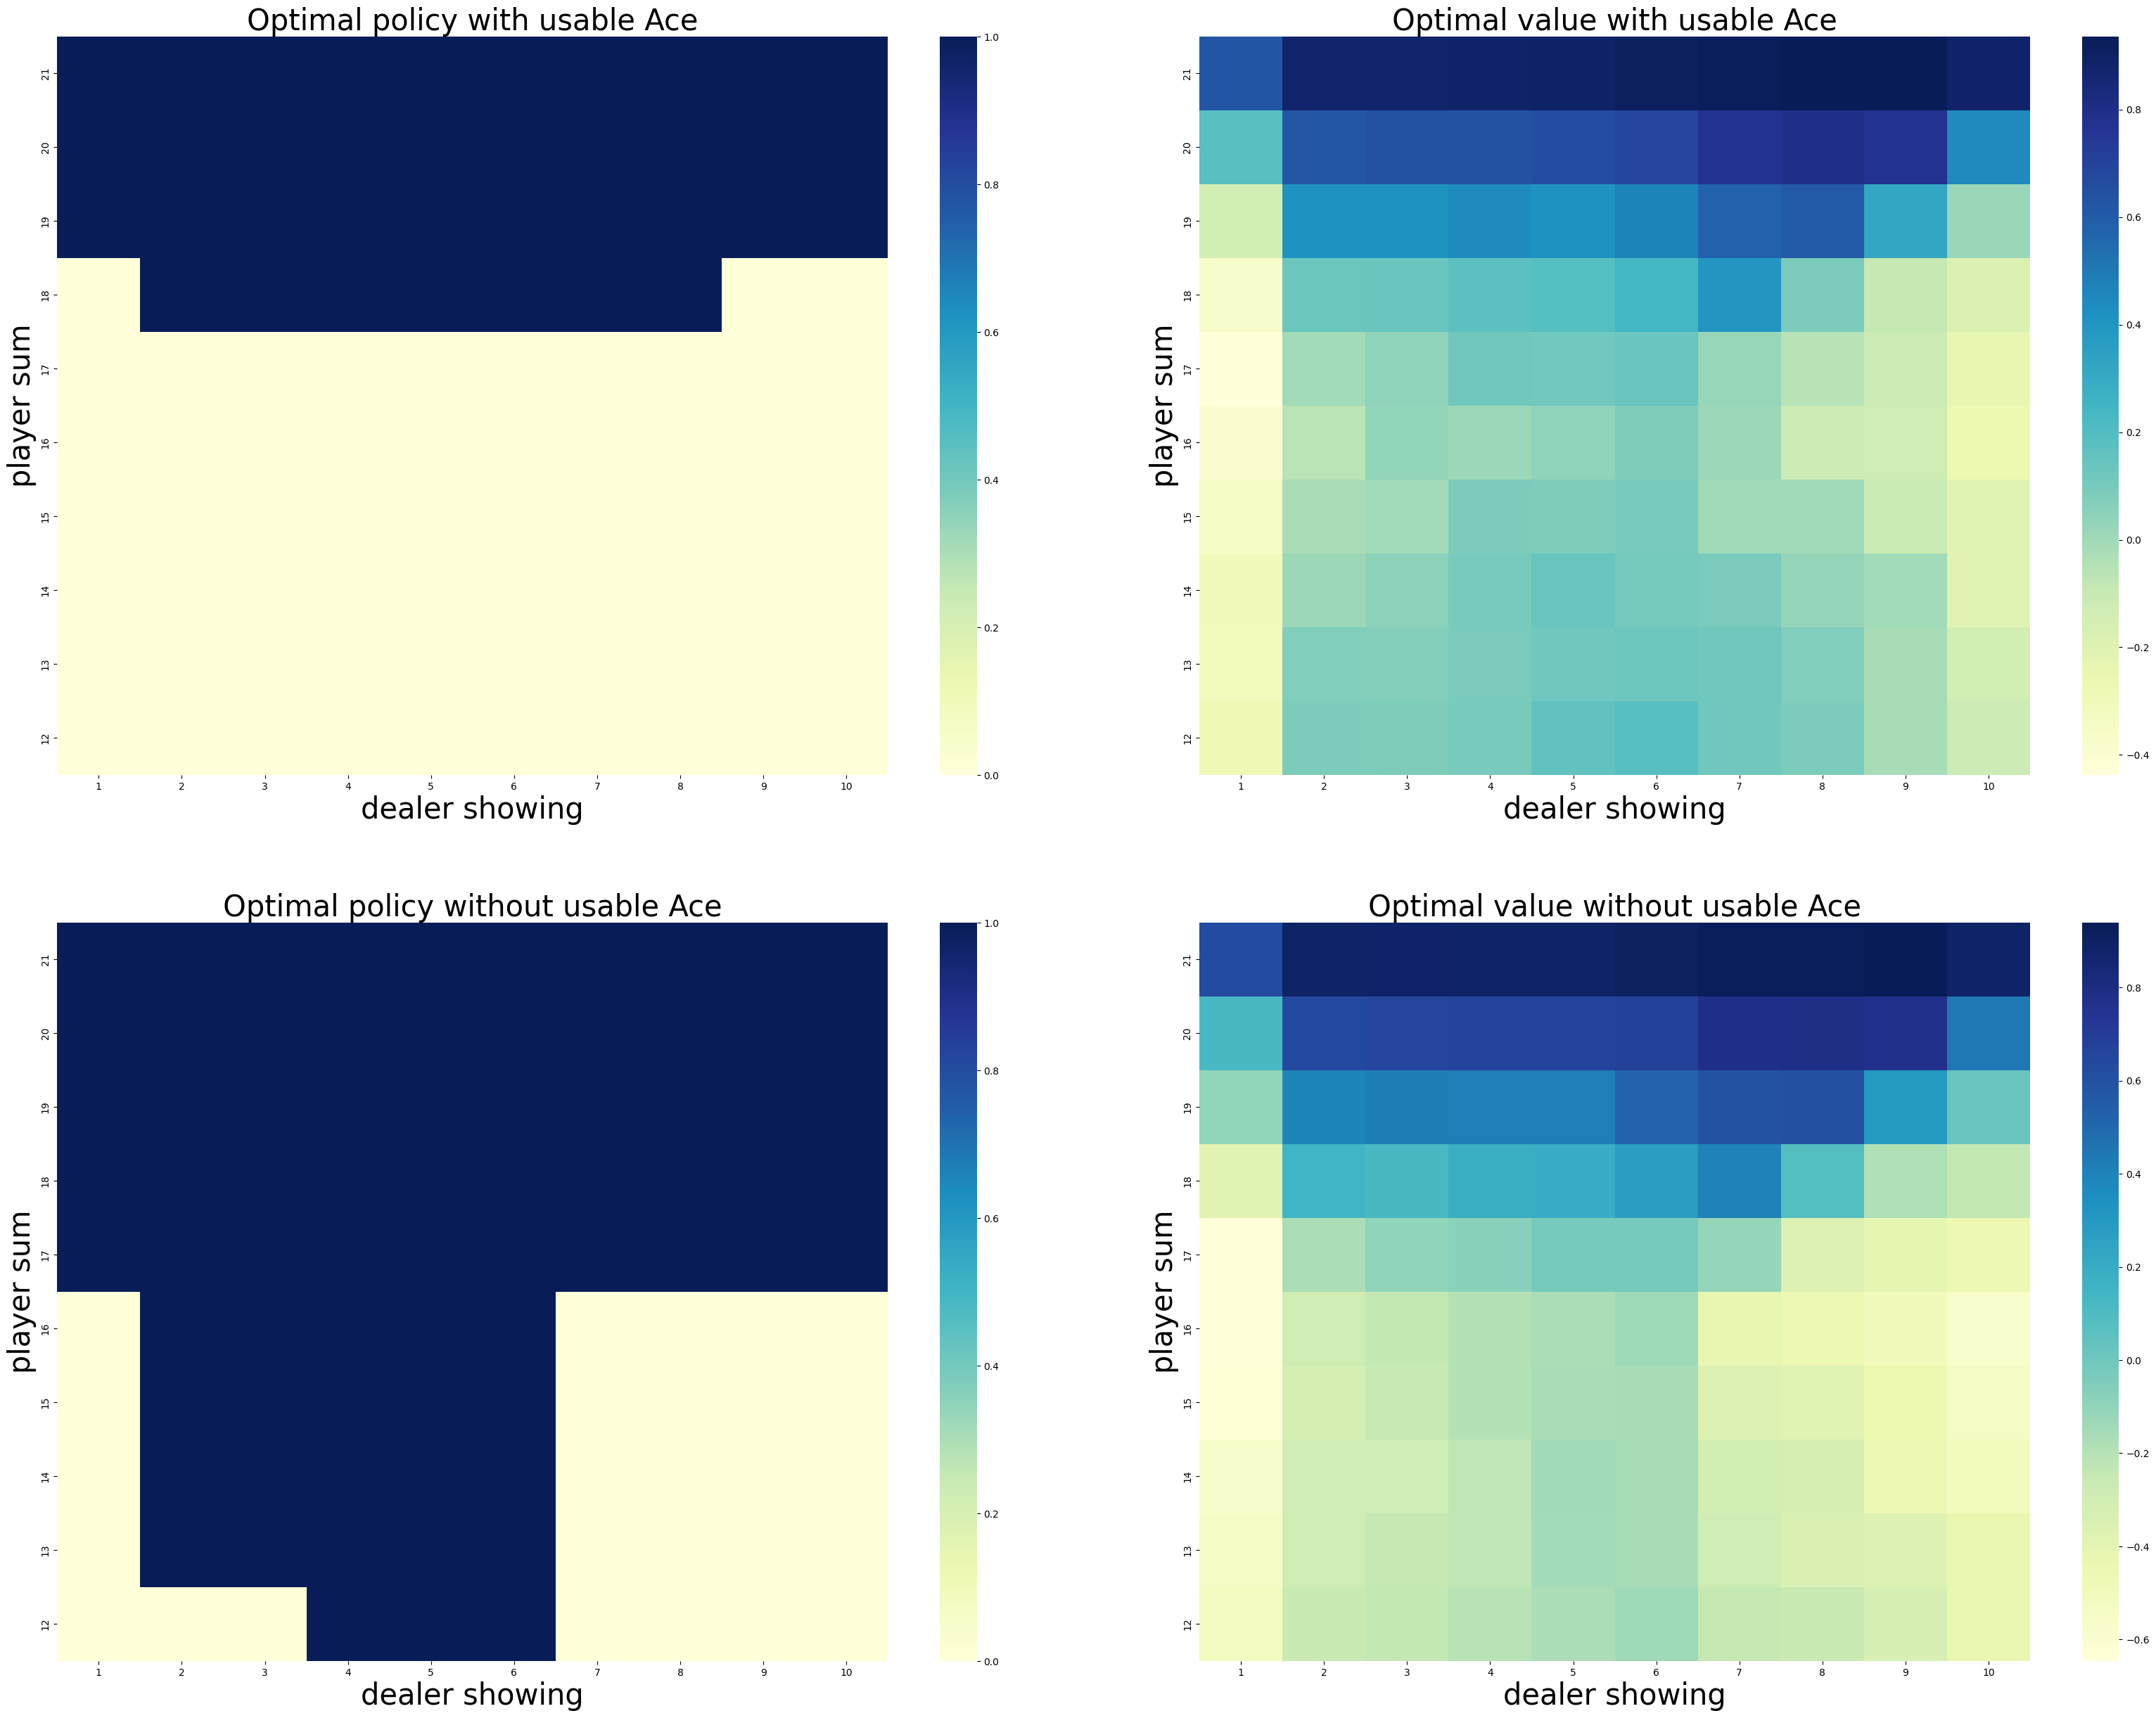

In [ ]:
state_action_values = monte_carlo_es(500000)

# Optimal value-function is obtained by taking the value of the best action
state_value_no_usable_ace = np.max(state_action_values[:, :, 0, :], axis=-1)
state_value_usable_ace = np.max(state_action_values[:, :, 1, :], axis=-1)

# get the optimal policy
# Optimal policy is obtained by considering the best action
action_no_usable_ace = np.argmax(state_action_values[:, :, 0, :], axis=-1)
action_usable_ace = np.argmax(state_action_values[:, :, 1, :], axis=-1)

images = [action_usable_ace,
          state_value_usable_ace,
          action_no_usable_ace,
          state_value_no_usable_ace]

titles = ['Optimal policy with usable Ace',
          'Optimal value with usable Ace',
          'Optimal policy without usable Ace',
          'Optimal value without usable Ace']

_, axes = plt.subplots(2, 2, figsize=(40, 30))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

for image, title, axis in zip(images, titles, axes):
    fig = sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                      yticklabels=range(21, 11, -1))
    axis.set_ylim(10, 0)
    fig.set_ylabel('player sum', fontsize=30)
    fig.set_xlabel('dealer showing', fontsize=30)
    fig.set_title(title, fontsize=30)

plt.show()
plt.close()


**Figure 5.3**: Estimate trends over episodes for the *Mean Squared Error* of the value-function with *Off-Policy Monte Carlo*, up to 10000 episodes.

Comparison between *ordinary* (unbiased, but with more variance) and *weighted* (biased, but with less variance) importance sampling.


100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


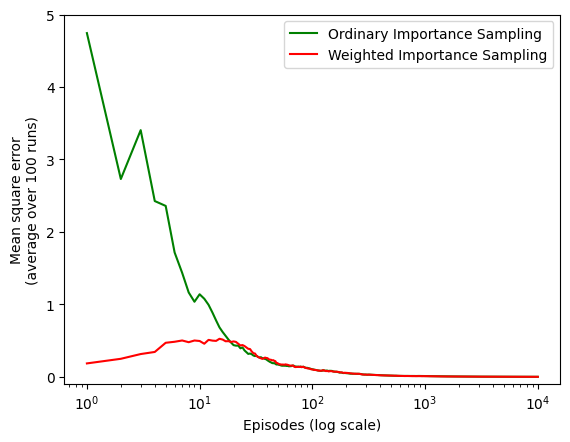

In [ ]:
true_value = -0.27726
episodes = 10000
runs = 100
error_ordinary = np.zeros(episodes)
error_weighted = np.zeros(episodes)
for i in tqdm(range(0, runs)):
    ordinary_sampling_, weighted_sampling_ = monte_carlo_off_policy(episodes)
    # get the squared error
    error_ordinary += np.power(ordinary_sampling_ - true_value, 2)
    error_weighted += np.power(weighted_sampling_ - true_value, 2)
error_ordinary /= runs
error_weighted /= runs

plt.plot(np.arange(1, episodes + 1), error_ordinary, color='green', label='Ordinary Importance Sampling')
plt.plot(np.arange(1, episodes + 1), error_weighted, color='red', label='Weighted Importance Sampling')
plt.ylim(-0.1, 5)
plt.xlabel('Episodes (log scale)')
plt.ylabel(f'Mean square error\n(average over {runs} runs)')
plt.xscale('log')
plt.legend()

plt.show()
plt.close()

**Off-Policy Monte Carlo control with (weighted) importance sampling**.

We want to estimate the value-function and optimal policy using the target policy defined at the beginning.

In [ ]:
behavior = 0.5 # equivalent to behavior_policy_player()

# Monte Carlo Sample with Off-Policy
def monte_carlo_off_policy_control(episodes):
    Q = np.zeros((10, 10, 2, 2))
    C = np.zeros((10, 10, 2, 2))

    for i in tqdm(range(0, episodes)):
        # Uses the random policy defined at the beginning
        _, reward, player_trajectory = play(behavior_policy_player)

        G = 0.0
        W = 1.0

        for (usable_ace, player_sum, dealer_card), action in player_trajectory[::-1]:
            G += reward
            usable_ace = int(usable_ace)
            player_sum -= 12
            dealer_card -= 1

            # Policy Evaluation
            C[player_sum, dealer_card, usable_ace, action] += W
            Q[player_sum, dealer_card, usable_ace, action] += (W / C[player_sum, dealer_card, usable_ace, action]) * (G - Q[player_sum, dealer_card, usable_ace, action])

            # Policy Improvement
            if action == np.argmax(Q[player_sum, dealer_card, usable_ace, :], axis=-1):
                num = 1
            else:
                break

            W = W * num/behavior

    return Q

Optimal policy and value-function found by Monte Carlo off policy in 500000 steps.

100%|██████████| 500000/500000 [00:22<00:00, 22582.63it/s]


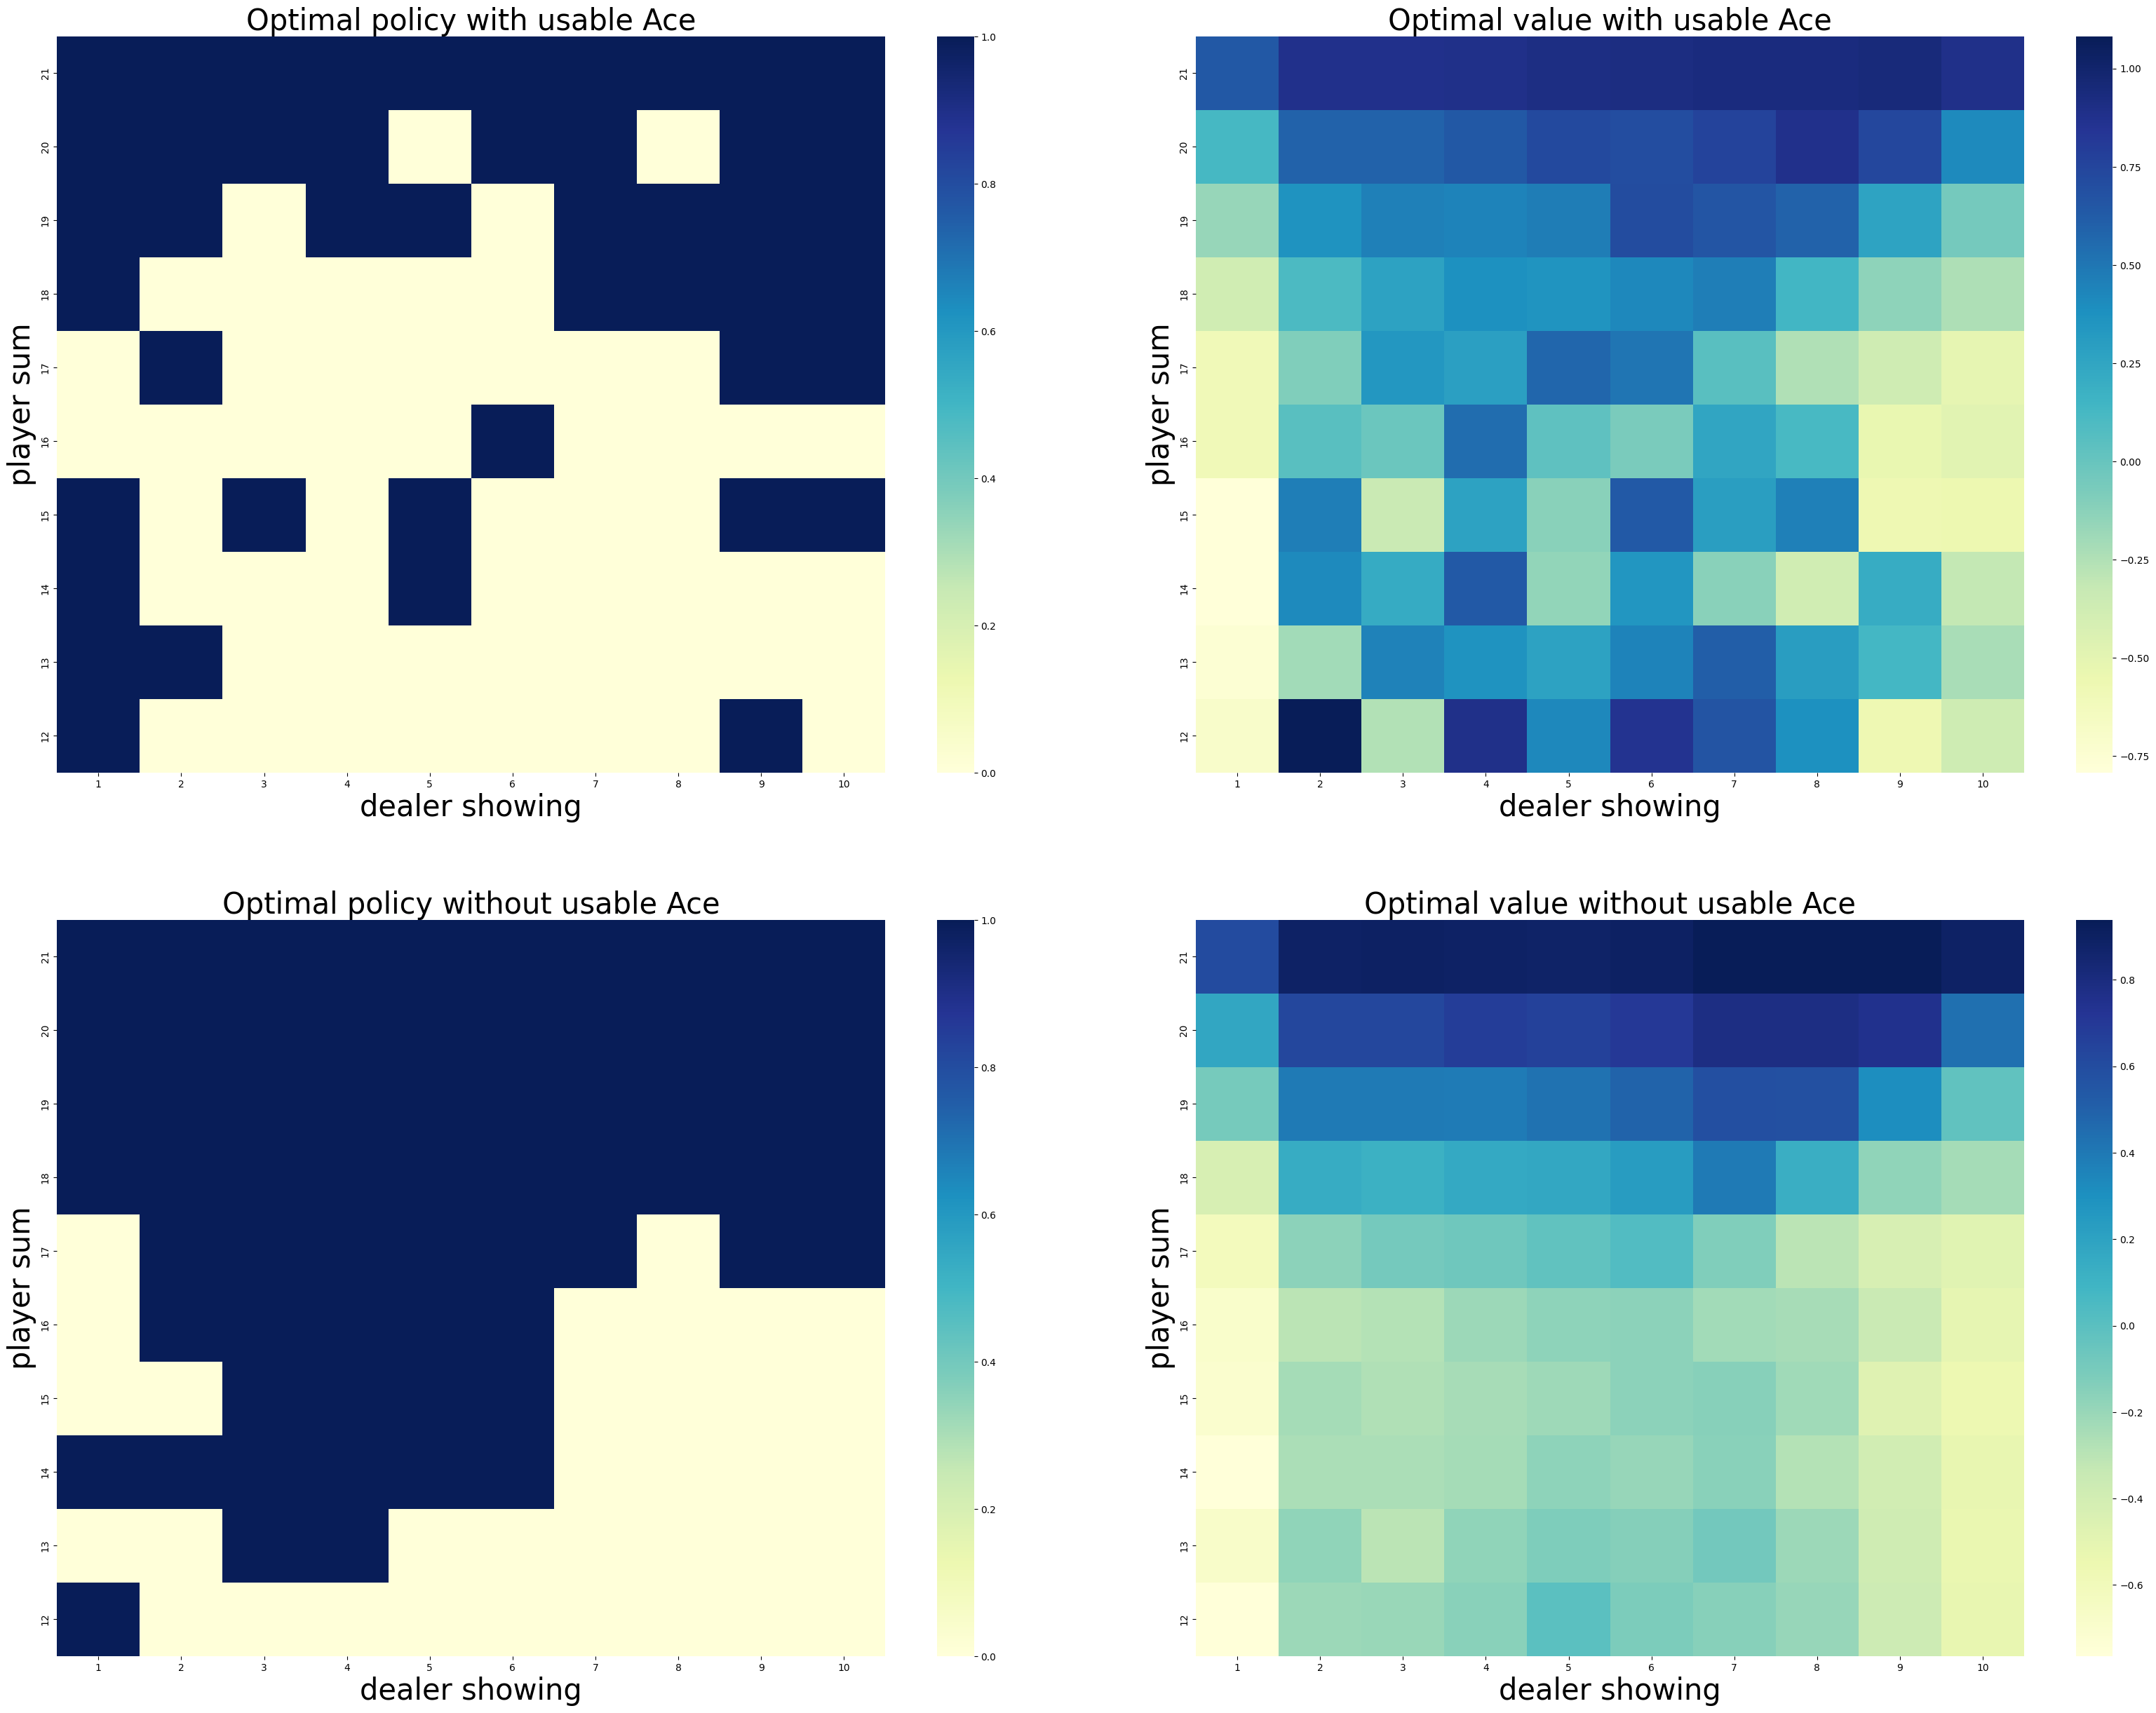

In [ ]:
state_action_values = monte_carlo_off_policy_control(500000)


# Optimal value-function is obtained by taking the value of the best action
state_value_no_usable_ace = np.max(state_action_values[:, :, 0, :], axis=-1)
state_value_usable_ace = np.max(state_action_values[:, :, 1, :], axis=-1)

# get the optimal policy
# Optimal policy is obtained by considering the best action
action_no_usable_ace = np.argmax(state_action_values[:, :, 0, :], axis=-1)
action_usable_ace = np.argmax(state_action_values[:, :, 1, :], axis=-1)

images = [action_usable_ace,
          state_value_usable_ace,
          action_no_usable_ace,
          state_value_no_usable_ace]
titles = ['Optimal policy with usable Ace',
          'Optimal value with usable Ace',
          'Optimal policy without usable Ace',
          'Optimal value without usable Ace']

_, axes = plt.subplots(2, 2, figsize=(40, 30))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

for image, title, axis in zip(images, titles, axes):
    fig = sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                      yticklabels=range(21, 11, -1))
    axis.set_ylim(10, 0)
    fig.set_ylabel('player sum', fontsize=30)
    fig.set_xlabel('dealer showing', fontsize=30)
    fig.set_title(title, fontsize=30)

plt.show()
plt.close()


In [ ]:
# Let's play!

def draw(face_up=True):
    card = get_card()
    if card==1 and face_up:
        print('Ace!')
    return card_value(card)

In [ ]:
# Setting the game...

player_sum = draw() + draw()
dealer_sum = draw()
print(f'Current player sum = {player_sum}')
print(f'Current dealer sum = {dealer_sum}')

Current player sum = 16
Current dealer sum = 10


In [ ]:
# Player hits!

player_sum += draw()
print(f'Current player sum = {player_sum}')

Current player sum = 18


In [ ]:
# Dealer draws the other card...

dealer_sum += draw()
print(f'Current dealer sum = {dealer_sum}')

Current dealer sum = 16


In [ ]:
# Dealer hits!

dealer_sum += draw()
print(f'Current dealer sum = {dealer_sum}')

Ace!
Current dealer sum = 27


In [ ]:
# Who wins?

busted_out = False

if player_sum > 21:
    busted_out = True
    print('Dealer wins!')
elif dealer_sum > 21:
    busted_out = True
    print('Player wins!')

if not busted_out:
    if dealer_sum > player_sum:
        print('Dealer wins!')
    if dealer_sum < player_sum:
        print('Player wins!')
    if dealer_sum == player_sum:
        print('Draw!')

Player wins!


In [ ]:
# Use usable ace! - PLAYER

player_sum -= 10
print(f'Current player sum = {player_sum}')

Current player sum = 8


In [ ]:
# Use usable ace! - DEALER

dealer_sum -= 10
print(f'Current dealer sum = {dealer_sum}')

Current dealer sum = 17
